In [ ]:
# https://github.com/zalandoresearch/pytorch-vq-vae
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

def one_hot_encode_sequences(seq, include_n=False):
    num_seq = []
    nucleotides = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
    for nucleotide in seq:
        num_seq.append(nucleotides[nucleotide])
    return (F.one_hot(torch.tensor(num_seq).to(torch.int64), num_classes=len(nucleotides))).T

class PeaksDataset(Dataset):
    def __init__(self, df):
        self.sequences = []
        for curr_seq in df['raw_sequence'].tolist():
            if len(curr_seq) != 200:
                mid_index = len(curr_seq)//2
                curr_seq = curr_seq[mid_index-100:mid_index+100]

            one_hot_representation = one_hot_encode_sequences(curr_seq)
            if one_hot_representation is not None:
                one_hot_representation = one_hot_representation[None, :, :]
                self.sequences.append(one_hot_representation)

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], 1

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings, encoding_indices

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings, encoding_indices

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=(4, 10),
                                 stride=2, padding=(1, 4))
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=1,
                                                kernel_size=(2, 12), 
                                                stride=2, padding=(0, 5))

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

In [ ]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [ ]:
!curl -L -o train_all_classifier_WM20220916.csv.gz "https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2"

In [ ]:
!gunzip train_all_classifier_WM20220916.csv.gz

In [ ]:
import pandas as pd
df = pd.read_csv('../content/train_all_classifier_WM20220916.csv', delimiter='\t')
train_df = df[(df['seqname'] != 'chr3') & (df['seqname'] != 'chr15')]
test_df = df[(df['seqname'] == 'chr3') | (df['seqname'] == 'chr15')]

peaks_data = PeaksDataset(train_df)
BATCH_SIZE = 128
peaks_dl = DataLoader(peaks_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _, encoding_index = self._vq_vae(z)
        x_recon = self._decoder(quantized)
        return loss, x_recon, perplexity, quantized, encoding_index

In [ ]:
device = 'cuda'
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# with adjusted kernel size to capture motifs
import numpy as np
train_res_recon_error = []
train_res_perplexity = []

for epoch in range(250):
    for i, (data, _) in enumerate(peaks_dl):
        data = data.to(device).float()
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity, hidden_quantized, encoding_index = model(data)
        recon_error = F.mse_loss(data_recon, data) / 1
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        if (i+1) % 100 == 0:
            print('%d iterations' % (i+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
            print()

100 iterations
recon_error: 0.132
perplexity: 11.542

200 iterations
recon_error: 0.118
perplexity: 15.433

300 iterations
recon_error: 0.108
perplexity: 15.494

400 iterations
recon_error: 0.104
perplexity: 15.853

500 iterations
recon_error: 0.104
perplexity: 17.535

600 iterations
recon_error: 0.099
perplexity: 29.922

700 iterations
recon_error: 0.090
perplexity: 38.701

800 iterations
recon_error: 0.073
perplexity: 41.966

900 iterations
recon_error: 0.069
perplexity: 44.501

1000 iterations
recon_error: 0.065
perplexity: 44.831

100 iterations
recon_error: 0.060
perplexity: 48.893

200 iterations
recon_error: 0.058
perplexity: 50.086

300 iterations
recon_error: 0.054
perplexity: 52.138

400 iterations
recon_error: 0.053
perplexity: 52.915

500 iterations
recon_error: 0.054
perplexity: 53.448

600 iterations
recon_error: 0.054
perplexity: 53.681

700 iterations
recon_error: 0.054
perplexity: 53.976

800 iterations
recon_error: 0.055
perplexity: 54.762

900 iterations
recon_error:

KeyboardInterrupt: ignored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 24.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=59d3f162b8083c92696e88852c8342be659e02122bea60c68427244327030806
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=23860609ca905675e0a09ca11fc7fd4b673ce7f4987a0855ba2c9d67af79c408
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


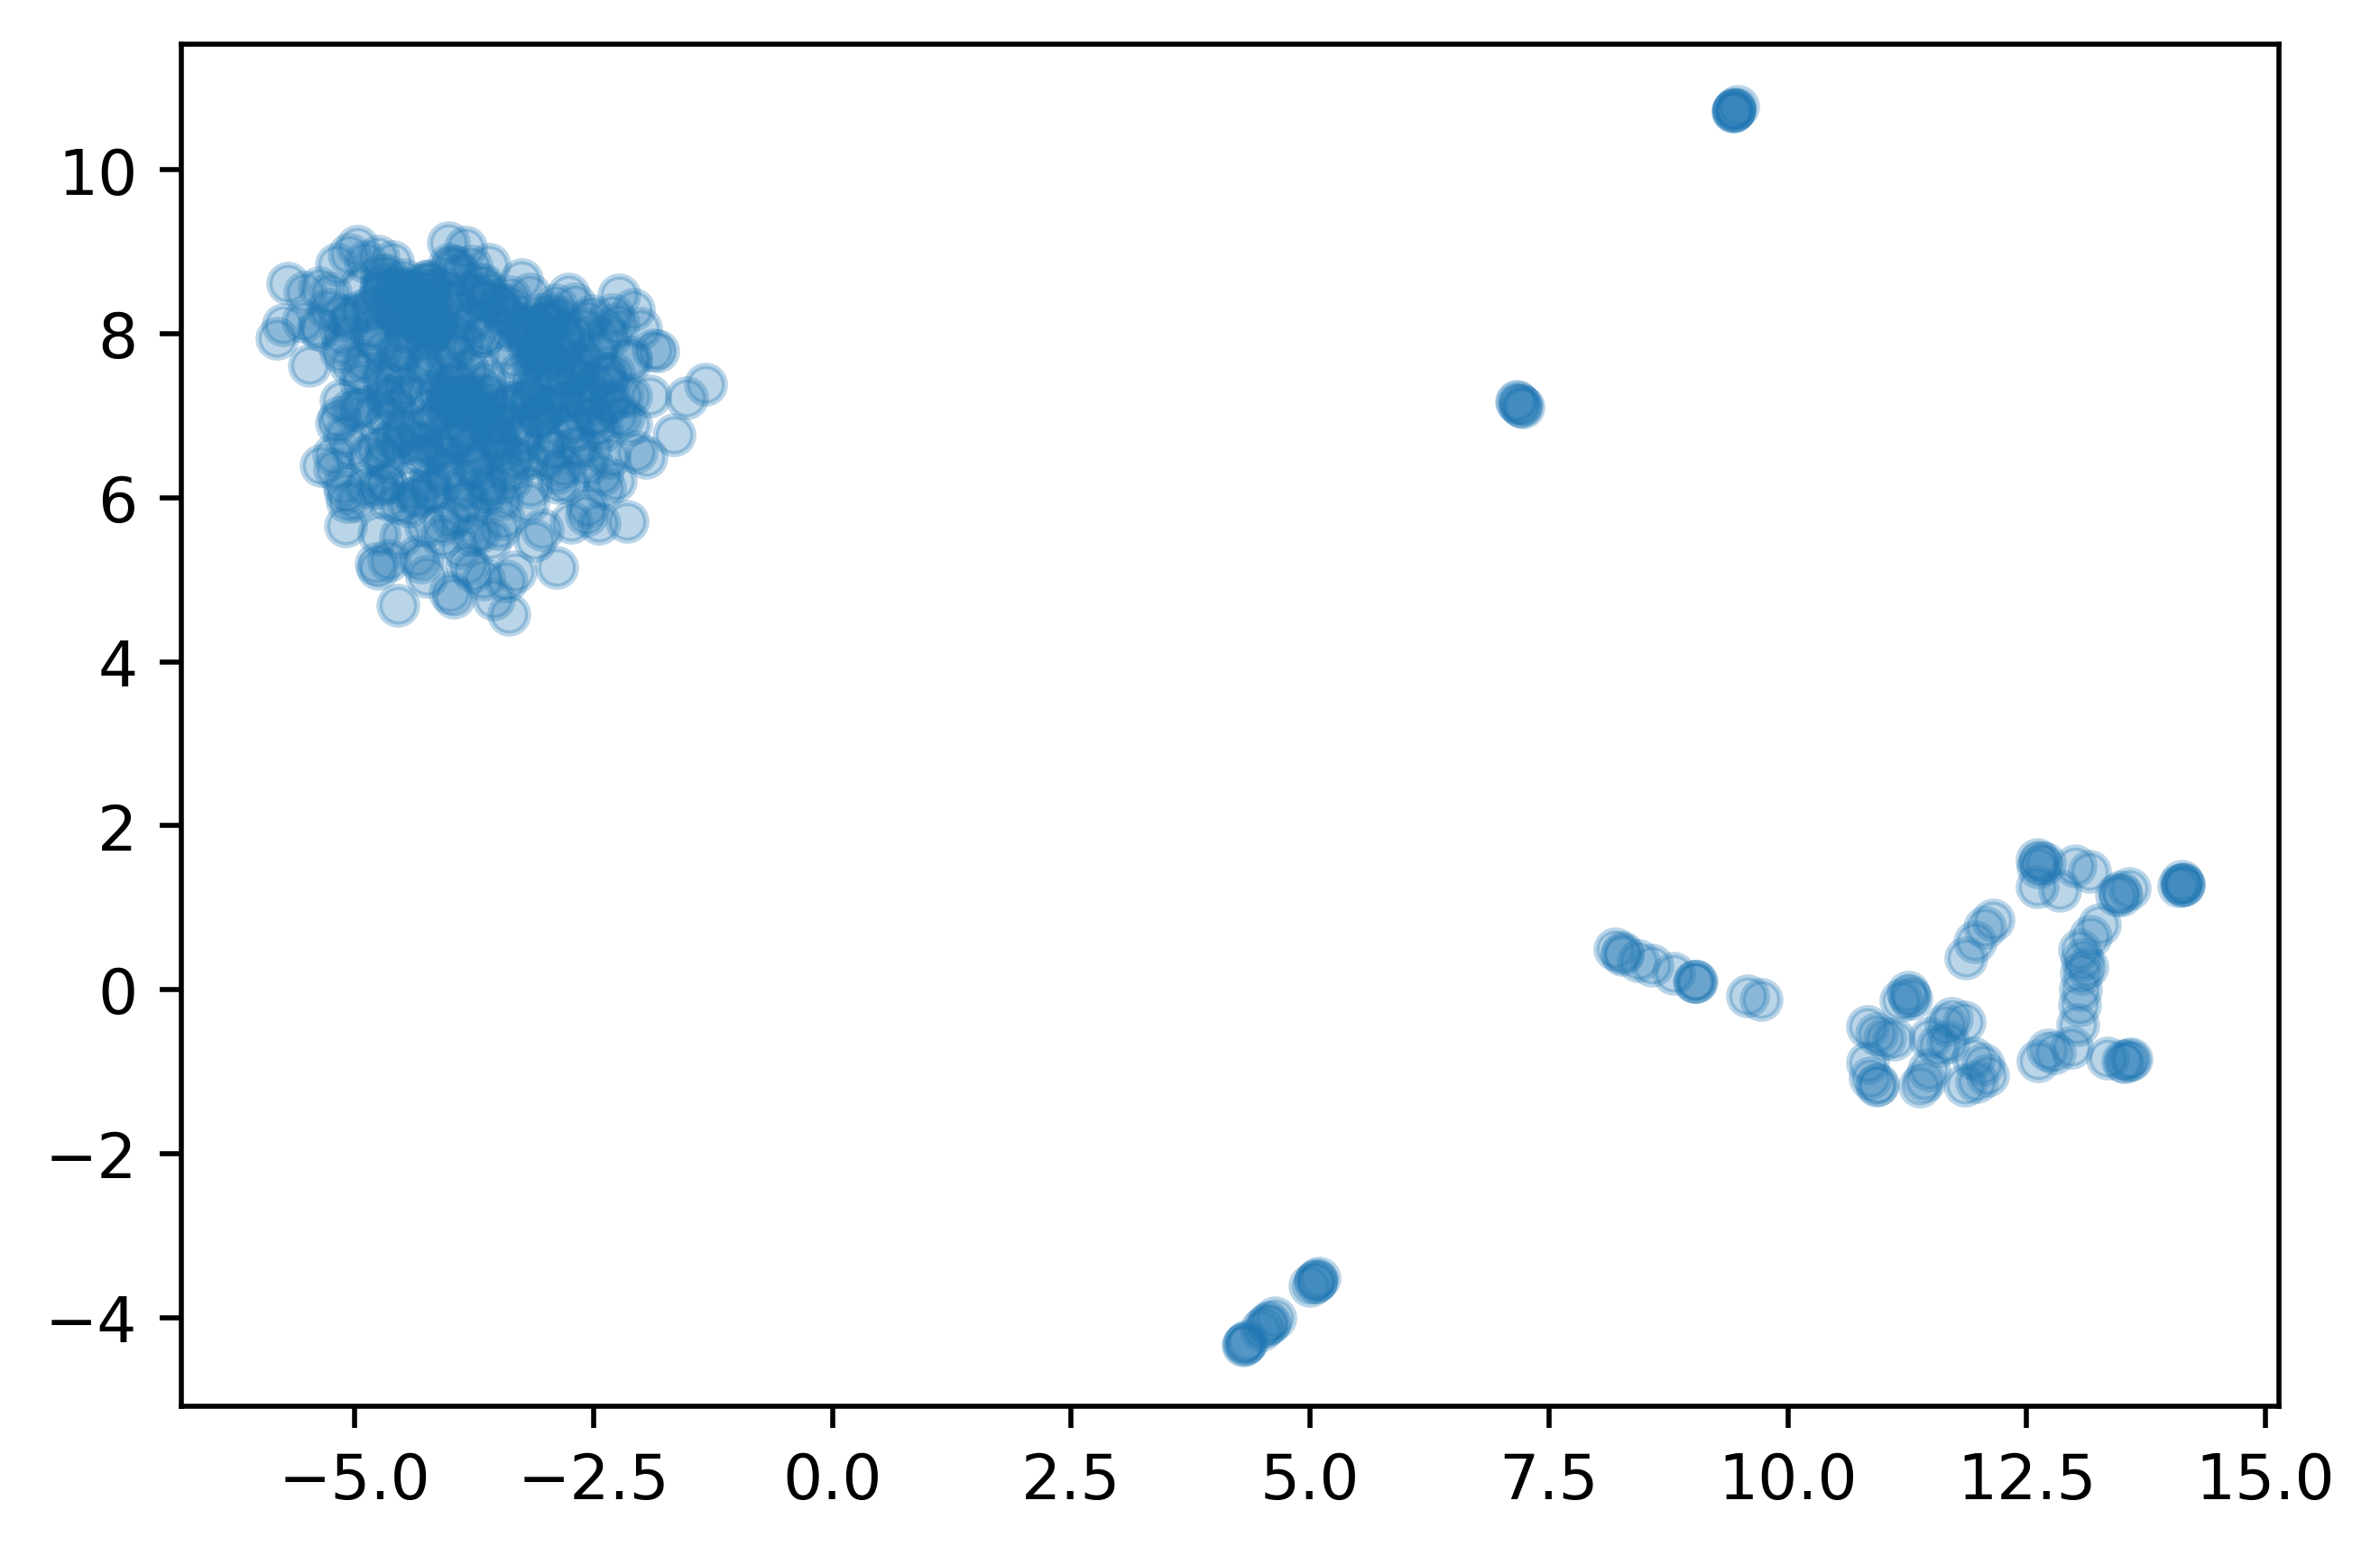

In [ ]:
!pip install umap-learn
import umap.umap_ as umap
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 500

proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

In [ ]:
test_data = PeaksDataset(test_df)
BATCH_SIZE = 64
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
model.eval()
correct = 0
tot = 0
incorrect_indices = []
incorrect_pred_val, correct_pred_val = [], []
incorrect_pos_nucleotides = np.zeros((4, 200))

for valid_originals, _ in test_dl:
    valid_originals = valid_originals.to(device).float()
    vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
    _, valid_quantize, _, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)
    ground_truth = torch.argmax(valid_originals, dim=2)
    prediction = torch.argmax(valid_reconstructions, dim=2)

    for i in range(valid_originals.shape[0]):
        correct += int((prediction[i][0] == ground_truth[i][0]).sum())
        t = (ground_truth[i][0] != prediction[i][0]).cpu().numpy().tolist()
        inds = [j for j in range(len(t)) if t[j]]
        for ind in inds:
            incorrect_pred_val.append(prediction[i][0][ind].item())
            correct_pred_val.append(ground_truth[i][0][ind].item())
            nucleotide = prediction[i][0][ind].item()
            incorrect_pos_nucleotides[nucleotide][ind] += 1
        incorrect_indices.extend(inds)
        tot += 200

In [ ]:
accuracy = correct/tot
num_incorrect = len(incorrect_indices)
accuracy, num_incorrect

(0.8713279434057605, 509284)